# AirBnB Listings in Los Angeles, CA
##### Data source: http://insideairbnb.com/get-the-data.html
##### Date compiled: May 8, 2020
## 2 - EDA

### Dependencies

In [21]:
from datetime import datetime
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import utils

%matplotlib inline

In [22]:
# Settings
pd.options.display.max_columns = 200
pd.options.display.max_rows = 50000
sns.set()
px.set_mapbox_access_token(utils.get_token())

### Data

In [23]:
reviews = pd.read_csv('data/reviews.csv')
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1304141 entries, 0 to 1304140
Data columns (total 6 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   listing_id     1304141 non-null  int64 
 1   id             1304141 non-null  int64 
 2   date           1304141 non-null  object
 3   reviewer_id    1304141 non-null  int64 
 4   reviewer_name  1304139 non-null  object
 5   comments       1303081 non-null  object
dtypes: int64(3), object(3)
memory usage: 59.7+ MB


In [24]:
listings = pd.read_pickle('data/listings_cleaned.pkl')
listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37028 entries, 0 to 37047
Data columns (total 38 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   id                                37028 non-null  int64         
 1   host_is_superhost                 37028 non-null  float64       
 2   neighbourhood_cleansed            37028 non-null  object        
 3   zipcode                           37028 non-null  object        
 4   latitude                          37028 non-null  float64       
 5   longitude                         37028 non-null  float64       
 6   property_type                     37028 non-null  object        
 7   room_type                         37028 non-null  object        
 8   accommodates                      37028 non-null  int64         
 9   bathrooms                         37028 non-null  float64       
 10  bedrooms                          37028 non-nu

### Rename and recast columns

In [25]:
# Rename columns to simpler names
listings.rename(columns={'host_is_superhost': 'by_superhost',
                         'review_scores_rating': 'score_rating'}, inplace=True)

# Cast `by_superhost` as integer type
listings['by_superhost'] = listings.by_superhost.astype(int)
listings.head(2)

,id,by_superhost,neighbourhood_cleansed,zipcode,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,first_review,last_review,score_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month
0,109,0,Culver City,90230,33.98209,-118.38494,Condominium,Entire home/apt,6,2.0,2.0,3.0,122.0,500.0,240.0,3,25.0,30,0,0,0,38,2,0,2011-08-15,2016-05-15,80.0,10.0,10.0,6.0,8.0,10.0,8.0,0,strict_14_with_grace_period,1,0,0.02
1,344,0,Burbank,91505,34.16562,-118.33458,House,Entire home/apt,6,1.0,3.0,3.0,168.0,0.0,100.0,6,0.0,15,0,1,6,97,8,2,2016-06-14,2019-10-19,97.0,10.0,10.0,10.0,10.0,10.0,10.0,1,flexible,0,0,0.17


### Filter out listings with an outlier price

In [26]:
list765 = listings[listings.price <= 765].copy()
list765.describe()

,id,by_superhost,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,score_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month
count,3.556300e+04,35563.000000,35563.000000,35563.000000,35563.000000,35563.000000,35563.000000,35563.000000,35563.000000,35563.000000,35563.000000,35563.000000,35563.000000,35563.000000,35563.000000,35563.000000,35563.000000,35563.000000,35563.000000,35563.000000,28295.000000,28248.000000,28249.000000,28238.000000,28247.000000,28234.000000,28230.000000,35563.000000,35563.000000,35563.000000,35563.000000
mean,2.505182e+07,0.328797,34.050258,-118.313326,3.442032,1.371439,1.344740,1.862947,140.761016,269.070410,76.392655,1.848466,14.443916,15.482833,14.973849,32.450384,50.488120,165.779406,36.362371,12.142733,94.269553,9.612928,9.416652,9.748212,9.717386,9.705001,9.432944,0.436015,0.013582,0.021258,1.312094
std,1.280203e+07,0.469783,0.121526,0.163990,2.410231,0.772871,0.972507,1.518274,115.610321,594.610912,79.641091,1.594151,24.709441,11.178341,13.336440,25.868994,38.232703,142.389288,65.212058,18.640812,9.013689,0.887676,1.008461,0.774724,0.827613,0.730063,0.935986,0.495896,0.115747,0.144245,1.707011
min,1.090000e+02,0.000000,33.338830,-118.934220,1.000000,0.000000,0.000000,0.000000,10.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,1.498344e+07,0.000000,33.997370,-118.419410,2.000000,1.000000,1.000000,1.000000,68.000000,0.000000,20.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2.000000,1.000000,0.000000,93.000000,9.000000,9.000000,10.000000,10.000000,10.000000,9.000000,0.000000,0.000000,0.000000,0.080000
50%,2.612833e+07,0.000000,34.060980,-118.340130,2.000000,1.000000,1.000000,1.000000,100.000000,100.000000,55.000000,1.000000,5.000000,15.000000,17.000000,38.000000,66.000000,147.000000,9.000000,3.000000,97.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,0.000000,0.000000,0.000000,0.580000
75%,3.672257e+07,1.000000,34.104125,-118.248790,4.000000,1.500000,2.000000,2.000000,172.000000,300.000000,100.000000,2.000000,20.000000,30.000000,29.000000,59.000000,89.000000,333.000000,42.000000,17.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000,0.000000,0.000000,1.980000
max,4.338380e+07,1.000000,34.811190,-117.652640,24.000000,11.500000,11.000000,50.000000,754.000000,5100.000000,749.000000,24.000000,300.000000,30.000000,30.000000,60.000000,90.000000,365.000000,822.000000,211.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000,1.000000,1.000000,17.230000


### Is there a difference with listings by superhosts?

,regular_hosts,superhosts
count,23870.000000,11693.000000
mean,139.162673,144.023860
std,117.277288,112.064673
min,10.000000,10.000000
25%,65.000000,75.000000
50%,100.000000,110.000000
75%,170.000000,175.000000
max,752.000000,754.000000


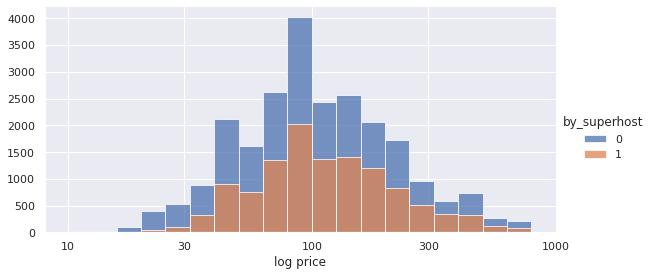

In [46]:
# Tick labels
ticks = [10, 30, 100, 300, 1000]

# Price distribution for listings by regular hosts and superhosts
grid = sns.FacetGrid(data=list765, hue='by_superhost', height=4, aspect=2)
grid.map(plt.hist, 'price', bins=10**np.arange(1,3,0.1), alpha=0.75).set(xscale='log')
grid.set(xticks=ticks, xticklabels=ticks, xlabel='log price')
grid.add_legend()

# Descriptive statistics of price
host_price = list765[list765.by_superhost == 0][['price']].describe()
host_price.columns = ['regular_hosts']
host_price['superhosts'] = list765.loc[list765.by_superhost == 1, 'price'].describe()
host_price

,regular_hosts,superhosts
count,17439.000000,10856.000000
mean,92.211767,97.575166
std,10.673836,3.319286
min,20.000000,20.000000
25%,90.000000,97.000000
50%,95.000000,98.000000
75%,100.000000,100.000000
max,100.000000,100.000000


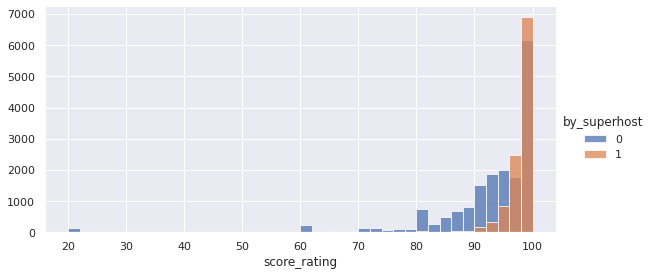

In [47]:
# Rating distribution of listings by regular hosts and superhosts
grid = sns.FacetGrid(data=list765, hue='by_superhost', height=4, aspect=2)
grid.map(plt.hist, 'score_rating', bins=40, alpha=0.75)
grid.add_legend()

# Descriptive statistics of rating
host_rating = list765[list765.by_superhost == 0][['score_rating']].describe()
host_rating.columns = ['regular_hosts']
host_rating['superhosts'] = list765.loc[list765.by_superhost == 1, 'score_rating'].describe()
host_rating

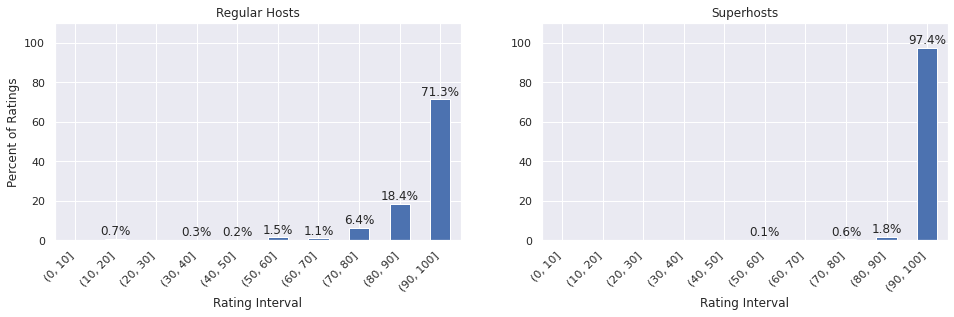

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

utils.hist_pct(list765, ax[0], filter_val=0, title='Regular Hosts', xlab='Rating Interval', ylab='Percent of Ratings')
utils.hist_pct(list765, ax[1], filter_val=1, title='Superhosts', xlab='Rating Interval')

In [50]:
# 2-sample t-test
reghost = list765[list765.by_superhost == 0].copy()
suphost = list765[list765.by_superhost == 1].copy()
stats.ttest_ind(reghost.score_rating.dropna(), suphost.score_rating.dropna(), equal_var=False)

Ttest_indResult(statistic=-61.73398959958312, pvalue=0.0)

***
##### 
***